In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_hdf("data/ID18150/Day2/DataFrame_Imaging_dFF_18150_day2.h5")

In [4]:
# Get a list of columns whose names are of numerical type
numerical_columns = [col for col in df.columns if type(col) == int]

#Feature matrix
X = df[numerical_columns].values
t = df.Time.to_list()

In [5]:
delta = 5000
def get_x_ticks(L:int):
    x_ticks = np.arange(0,L,delta)
    x_tick_labels = [f"{t[i]/100:.2f}" for i in x_ticks]
    return x_ticks, x_tick_labels

In [6]:
split = int(0.2*len(X))
X_train, X_test = X[:-split], X[-split:]
y_train, y_test = df["Pump"].values[:-split], df["Pump"].values[-split:]
X_train.shape, X_test.shape

((52796, 709), (13198, 709))

## Autoencoder

This model works on the hypothesis that a response $X(t)$ is caused by a lagged stimulus $y(t - \tau)$. Thus, it tries to map $X(t + \tau) \mapsto y(t)$ by reversing time and taking a certain lag window of size $\tau$.

In [49]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, window_size = 512):
        self.X = X
        self.y = y
        self.window_size = window_size

    def __len__(self):
        return self.X.shape[0] - self.window_size

    def __getitem__(self, idx):
        y = self.y[idx]
        U = self.X[idx:idx+self.window_size, ::-1] #Time reversal
        U = torch.tensor(U.copy(), dtype=torch.float32).T.to(device)
        y = torch.tensor(y, dtype=torch.float32).to(device)
        return U, y

In [50]:
input_dim = X_train.shape[1]
conv_kernel_size = 10
window_size = 64

class AutoEncoder(torch.nn.Module):
    def __init__(self, input_dim, conv_dim, hidden_size):
        super(AutoEncoder, self).__init__()
        self.inpuit_dim = input_dim
        self.conv_dim = conv_dim
        self.hidden_size = hidden_size

        self.conv = torch.nn.Conv1d(in_channels=input_dim, out_channels=input_dim, kernel_size=conv_dim)
        self.rnn = torch.nn.GRU(input_size=input_dim, hidden_size=hidden_size, num_layers=1)
        self.fc = torch.nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = self.conv(x) #N, C, L
        x = torch.permute(x, (2, 0, 1))
        x, _ = self.rnn(x)
        x = torch.permute(x, (1, 0, 2))
        x = x[:,-1,:]
        x = self.fc(x)
        x = torch.sigmoid(x).flatten()
        return x

In [51]:
model = AutoEncoder(input_dim, conv_kernel_size, 8).to(device)
data = Dataset(X_train, y_train, window_size=window_size)
loader = torch.utils.data.DataLoader(data, batch_size=1024, shuffle=True)
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

100%|██████████| 5/5 [03:36<00:00, 43.30s/it, Loss=0.0406]


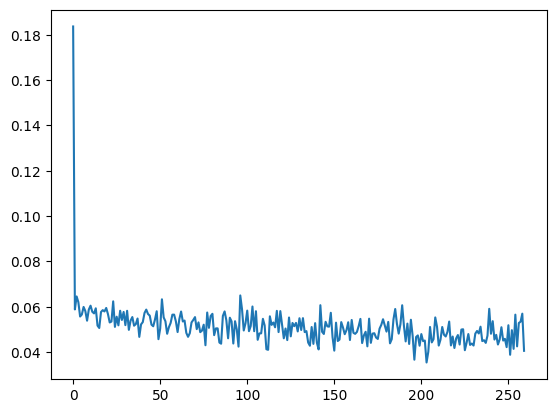

In [52]:
losses = []
pbar = tqdm(range(5))
for epoch in pbar:
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        l = loss(y_pred, y_batch)
        l.backward()
        optimizer.step()
        losses.append(l.item())
    pbar.set_postfix({"Loss":l.item()})
    scheduler.step()

plt.plot(losses)
plt.show()

In [53]:
# Prepare the test dataset
test_data = Dataset(X_test, y_test, window_size=window_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=512, shuffle=False)

# Get predictions for the test data
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(model(X_batch).cpu().numpy())

# Calculate R² score
r2 = r2_score(y_true, y_pred)
print(f"R² score: {r2}")

R² score: -0.0057211138798543


In [54]:
# Monte Carlo simulation to compare R² value against random assignment
num_trials = 1000
random_r2_scores = []

for _ in range(num_trials):
    random_predictions = np.random.rand(len(y_test))
    random_r2 = r2_score(y_test, random_predictions)
    random_r2_scores.append(random_r2)

expected_r2 = np.mean(random_r2_scores)
print(f"Expected R² score from random assignment: {expected_r2}")

Expected R² score from random assignment: -6.382806069790196


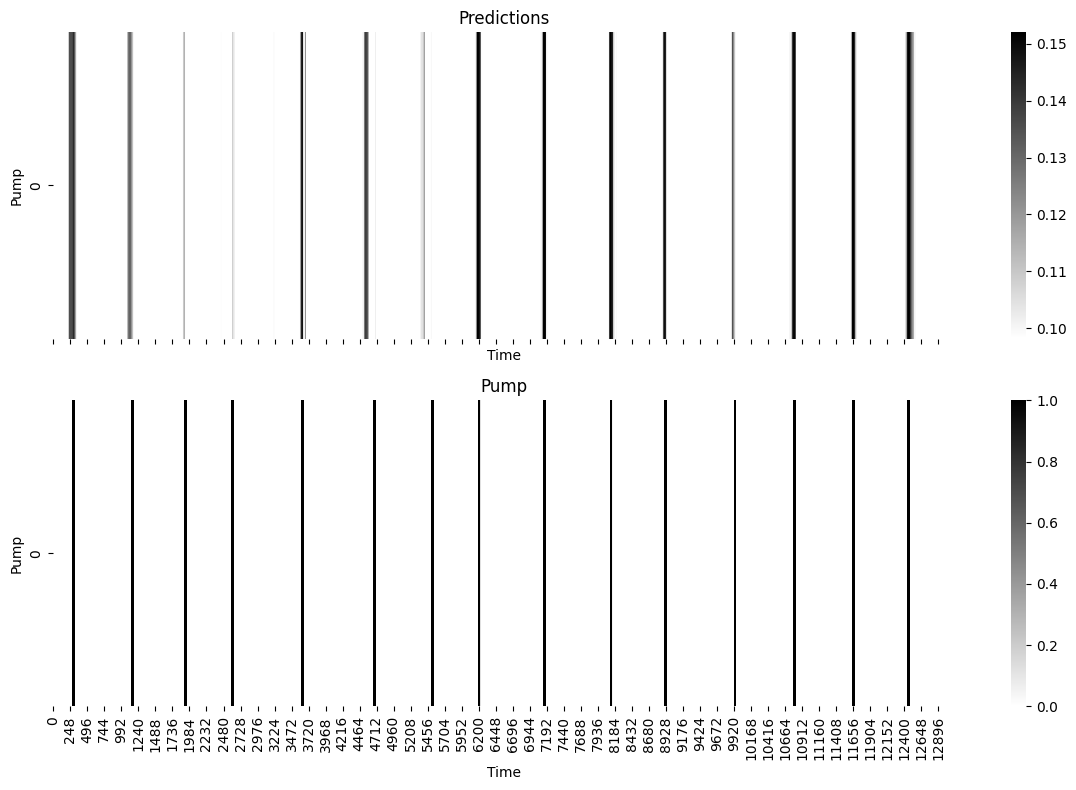

In [55]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

# Plot Pump data
sns.heatmap(np.array(y_true).reshape(1, -1), ax=ax2, cmap='gray_r')
ax2.set_xlabel('Time')
ax2.set_ylabel('Pump')
ax2.set_title('Pump')

# Plot predictions
sns.heatmap(np.array(y_pred).reshape(1, -1), ax=ax1, cmap='gray_r')
ax1.set_xlabel('Time')
ax1.set_ylabel('Pump')
ax1.set_title('Predictions')

plt.tight_layout()
plt.show()